# Library install

In [ ]:
# ! pip install nibabel pandas numpy scipy openpyxl imageio 
!pip install SimpleITK==2.1.1
!pip install torchio 
!pip install einops 
!pip install surfa
!pip install pytorch_lightning

!git clone https://github.com/drsehid/skull_stripping.git
import sys
sys.path.append('C:/Users/USER/Desktop/브레이니화_딥러닝/dataset/skull_stripping')


# 2d UNet
### 3d 코드를 임의로 2d에 적용 가능하도록 변경 시도함
### Skull stripping 깃허브 참고

Coronal images: 422
Masked Coronal images: 422
Sagittal images: 422
Masked Sagittal images: 422


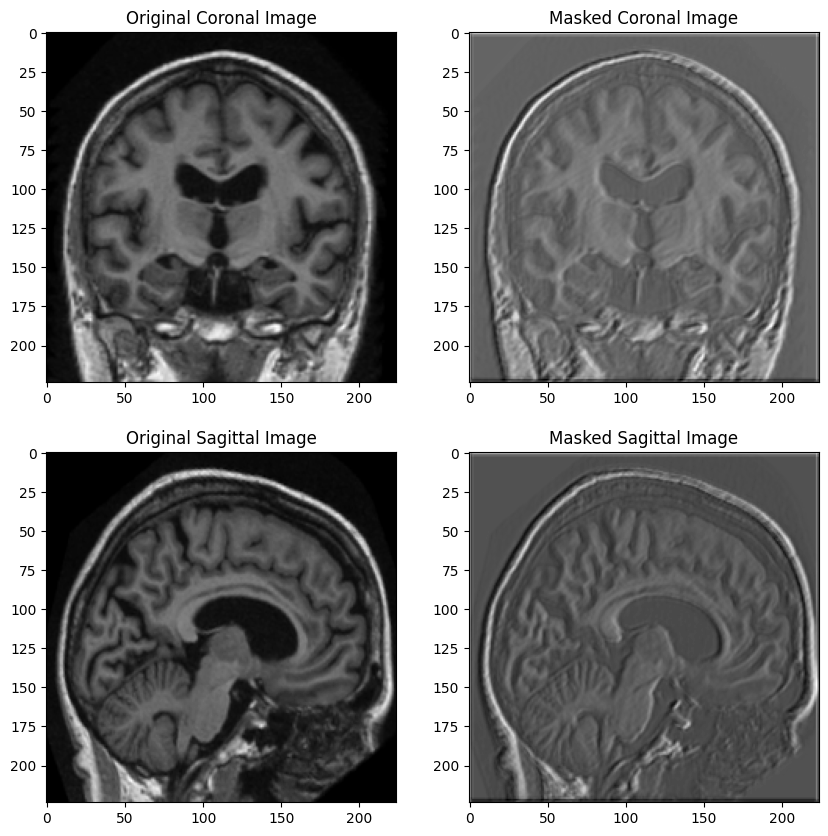

In [3]:
import os
import imageio
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 2D UNet 모델 정의
class UNet2D(nn.Module):
    def __init__(self):
        super(UNet2D, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 두개골 제거 적용 함수
def apply_skull_stripping(image, model, device):
    model.eval()
    with torch.no_grad():
        # 입력 이미지를 정규화 및 텐서로 변환
        input_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float().to(device)
        output = model(input_tensor)
        return output.squeeze().cpu().numpy()  # Thresholding 제거

####################################
## 0. 데이터 로드 및 기본 전처리
####################################
excel_file_path = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx"
data_dir = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset"
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]
df = df.dropna(subset=['CDR'])

# MRI 이미지 및 demographic 데이터 저장을 위한 딕셔너리
coronal_images = {}
sagittal_images = {}
masked_coronal_images = {}
masked_sagittal_images = {}
labels = []
demographics = {}

# 이미지 크기 조정 함수 정의
def resize_image(image, new_shape=(224, 224)):
    current_shape = image.shape[:2]
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)]
    return zoom(image, zoom_factors)

# UNet 모델 로드 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet2D().to(device)

# 피험자 데이터 로드 및 전처리 유지
for disc_num in range(1, 13):
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")
    if not os.path.exists(disc_path):
        continue
    
    for sub_folder in os.listdir(disc_path):
        sub_folder_path = os.path.join(disc_path, sub_folder)
        if not os.path.isdir(sub_folder_path):
            continue
        
        for subject_dir in os.listdir(sub_folder_path):
            session_path = os.path.join(sub_folder_path, subject_dir)
            if not os.path.exists(session_path):
                continue
            
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    # Coronal 이미지 처리
                    if file.endswith("_cor_110.gif"):
                        img = imageio.v2.imread(file_path)
                        img_resized = resize_image(img) / 255.0  # 정규화 추가
                        coronal_images[subject_dir] = img_resized
                        masked_coronal_images[subject_dir] = apply_skull_stripping(img_resized, model, device)

                    # Sagittal 이미지 처리
                    elif file.endswith("_sag_95.gif"):
                        img = imageio.v2.imread(file_path)
                        img_resized = resize_image(img) / 255.0  # 정규화 추가
                        sagittal_images[subject_dir] = img_resized
                        masked_sagittal_images[subject_dir] = apply_skull_stripping(img_resized, model, device)

# 처리된 데이터 개수 확인
print(f"Coronal images: {len(coronal_images)}")
print(f"Masked Coronal images: {len(masked_coronal_images)}")
print(f"Sagittal images: {len(sagittal_images)}")
print(f"Masked Sagittal images: {len(masked_sagittal_images)}")

####################################
## 3. 결과 출력 (이미지 비교)
####################################
def display_images(coronal, masked_coronal, sagittal, masked_sagittal):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(coronal, cmap='gray')
    axes[0, 0].set_title('Original Coronal Image')
    axes[0, 1].imshow(masked_coronal, cmap='gray')
    axes[0, 1].set_title('Masked Coronal Image')
    axes[1, 0].imshow(sagittal, cmap='gray')
    axes[1, 0].set_title('Original Sagittal Image')
    axes[1, 1].imshow(masked_sagittal, cmap='gray')
    axes[1, 1].set_title('Masked Sagittal Image')
    plt.show()

# 첫 번째 피험자의 이미지 비교 출력
subject_id = list(coronal_images.keys())[0]
display_images(coronal_images[subject_id], masked_coronal_images[subject_id],
               sagittal_images[subject_id], masked_sagittal_images[subject_id])

# OpenCV로 직접 구현 시도
### Canny Edge Detection

In [ ]:
pip install opencv-python

Processing session: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1
Checking T88_111 path: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111
Loading coronal .gif file: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif
Loading sagittal .gif file: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0001_MR1\PROCESSED\MPRAGE\T88_111\OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif
Processing session: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0002_MR1
Checking T88_111 path: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0002_MR1\PROCESSED\MPRAGE\T88_111
Loading coronal .gif file: C:/Users/USER/Desktop/브레이니화_딥러닝/dataset\oasis_cross-sectional_disc1\disc1\OAS1_0002_MR1\PROCESSED\MPRAGE\

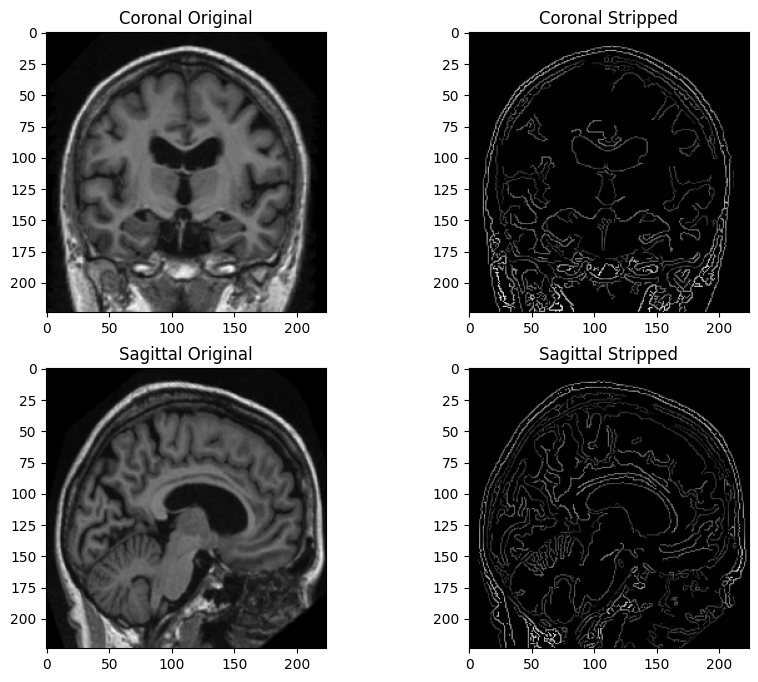

In [4]:
import os
import imageio
import numpy as np
import pandas as pd
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import torch
import surfa as sf
import cv2  # OpenCV 추가
import matplotlib.pyplot as plt  # 시각화를 위한 matplotlib 추가


####################################
## 0. 데이터 로드
####################################
# 경로 설정
excel_file_path = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx"
data_dir = "C:/Users/USER/Desktop/브레이니화_딥러닝/dataset"

# 엑셀 파일에서 인구통계학적 정보를 데이터프레임으로 로드 - 모든 정보를 가져옴
df = pd.read_excel(excel_file_path)
df = df[['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']]

####################################
## 1. 결측값 제거
####################################
# CDR 값이 없는 경우, 결측값으로 간주하고 제거
df = df.dropna(subset=['CDR'])

# MRI, label, 인구통계 정보를 위한 리스트와 딕셔너리 생성
coronal_images = {}
masked_coronal_images = {}
sagittal_images = {}
masked_sagittal_images = {}
transverse_images_gfc = {}
transverse_images_masked = {}
labels = []
demographics = {}

# 이미지 크기 조정 함수 정의 (이미지를 224x224로 변환)
def resize_image(image, new_shape=(224, 224)):
    current_shape = image.shape[:2]  # 2D 이미지이므로 앞의 두 차원만 사용 (높이, 너비)
    zoom_factors = [n / c for n, c in zip(new_shape, current_shape)] # 비율 차이 계산
    return zoom(image, zoom_factors) # 이미지 확대/축소 함수

# Canny Edge Detection을 사용한 두개골 제거
def canny_skull_strip(image):
    # Canny edge detection으로 경계선 찾기
    edges = cv2.Canny(image, 50, 150)

    # 외곽선을 마스크로 만듦
    mask = np.ones_like(image) * 255
    mask[edges == 0] = 0

    # 마스크를 적용하여 두개골만 제거
    stripped_image = cv2.bitwise_and(image, mask)
    return stripped_image

# 두개골 제거 전후의 이미지를 출력하는 함수
def plot_before_after(original, stripped, title):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Original {title}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(stripped, cmap='gray')
    plt.title(f'Stripped {title}')
    
    plt.show()

# 피험자 데이터 로드 및 저장
for disc_num in range(1, 13):  # 1~12 디스크 (OASIS 디스크 12개)
    disc_path = os.path.join(data_dir, f"oasis_cross-sectional_disc{disc_num}")
    
    if not os.path.exists(disc_path):
        print(f"Disc path does not exist: {disc_path}")
        continue
    
    for sub_folder in os.listdir(disc_path):
        sub_folder_path = os.path.join(disc_path, sub_folder)
        
        if not os.path.isdir(sub_folder_path):
            print(f"Skipping non-directory: {sub_folder_path}")
            continue
        
        for subject_dir in os.listdir(sub_folder_path):
            subject_path = os.path.join(sub_folder_path, subject_dir)
            
            if not os.path.isdir(subject_path):
                print(f"Skipping non-directory: {subject_path}")
                continue

            # MRI 경로 설정
            session_path = subject_path
            print(f"Processing session: {session_path}")

            if not os.path.exists(session_path):
                print(f"Session path does not exist: {session_path}")
                continue

            # preprocessed 데이터 경로 (T88_111 폴더)
            t88_111_path = os.path.join(session_path, "PROCESSED", "MPRAGE", "T88_111")
            print(f"Checking T88_111 path: {t88_111_path}")

            if os.path.exists(t88_111_path):
                for file in os.listdir(t88_111_path):
                    file_path = os.path.join(t88_111_path, file)

                    # coronal 이미지 처리
                    if file.endswith("_cor_110.gif"):
                        print(f"Loading coronal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)

                            # Canny Edge Detection으로 두개골 제거 적용
                            img_stripped = canny_skull_strip(img_resized)
                            coronal_images[subject_dir] = img_resized
                            masked_coronal_images[subject_dir] = img_stripped

                        except Exception as e:
                            print(f"Error loading coronal image: {e}")

                    # sagittal 이미지 처리
                    elif file.endswith("_sag_95.gif"):
                        print(f"Loading sagittal .gif file: {file_path}")
                        try:
                            img = imageio.v2.imread(file_path)
                            img_resized = resize_image(img)

                            # Canny Edge Detection으로 두개골 제거 적용
                            img_stripped = canny_skull_strip(img_resized)
                            sagittal_images[subject_dir] = img_resized
                            masked_sagittal_images[subject_dir] = img_stripped

                        except Exception as e:
                            print(f"Error loading sagittal image: {e}")

# 첫 번째 피험자의 이미지 비교 출력 함수 정의
def display_images(coronal, masked_coronal, sagittal, masked_sagittal):
    plt.figure(figsize=(10, 8))

    # Coronal 이미지 (원본 및 두개골 제거 후)
    plt.subplot(2, 2, 1)
    plt.imshow(coronal, cmap='gray')
    plt.title('Coronal Original')

    plt.subplot(2, 2, 2)
    plt.imshow(masked_coronal, cmap='gray')
    plt.title('Coronal Stripped')

    # Sagittal 이미지 (원본 및 두개골 제거 후)
    plt.subplot(2, 2, 3)
    plt.imshow(sagittal, cmap='gray')
    plt.title('Sagittal Original')

    plt.subplot(2, 2, 4)
    plt.imshow(masked_sagittal, cmap='gray')
    plt.title('Sagittal Stripped')

    plt.show()

# 첫 번째 피험자의 이미지 비교 출력
subject_id = list(coronal_images.keys())[0]
display_images(coronal_images[subject_id], masked_coronal_images[subject_id],
               sagittal_images[subject_id], masked_sagittal_images[subject_id])
